In [1]:
#Import all necessary libraries
import glob
import pandas as pd
import numpy as np

from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

import snappy
import fastparquet
import pyLDAvis
import pyLDAvis.gensim
import warnings
import _pickle as pickle

import re
import random
import collections
import seaborn as sns

from gensim import corpora, models
import gensim
import pyLDAvis.gensim

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from scipy import stats

pyLDAvis.enable_notebook()
random.seed(1234)

from sklearn.metrics.cluster import adjusted_rand_score
pd.options.display.max_columns = None

# 1. Topic Model on CommonCrawl


## 1.1. Loading and Filtering the Data
There are 28 files with ~2500 records each. 

In [2]:
%%time
#Load the parquet files into a single dataframe

result = pd.DataFrame()
#for filename in os.listdir("C:\\tmp\\my.tar\\istjoscha_cc_warc_wat_wet_acht_lang"):
for pth in sorted(glob.glob("./CC/*")):
    ds = pd.read_parquet(pth)
    #filter on English and university-related content
    ds = ds.loc[(ds['Guessed-Language']=='en') & (ds['Plaintext'].str.contains("niversity"))]
    print(pth)
    print(ds.shape)
    result = result.append(ds)
    print(result.shape)

#In case you are running out of memory, try to run the filter in the following paragraph on ds before appending

./CC/part-00000-fca7a267-5445-4edf-a466-0b66c0eec67e-c000.snappy.parquet
(95, 8)
(95, 8)
./CC/part-00001-fca7a267-5445-4edf-a466-0b66c0eec67e-c000.snappy.parquet
(87, 8)
(182, 8)
./CC/part-00002-fca7a267-5445-4edf-a466-0b66c0eec67e-c000.snappy.parquet
(97, 8)
(279, 8)
./CC/part-00003-fca7a267-5445-4edf-a466-0b66c0eec67e-c000.snappy.parquet
(84, 8)
(363, 8)
./CC/part-00004-fca7a267-5445-4edf-a466-0b66c0eec67e-c000.snappy.parquet
(80, 8)
(443, 8)
./CC/part-00005-fca7a267-5445-4edf-a466-0b66c0eec67e-c000.snappy.parquet
(99, 8)
(542, 8)
./CC/part-00006-fca7a267-5445-4edf-a466-0b66c0eec67e-c000.snappy.parquet
(96, 8)
(638, 8)
./CC/part-00007-fca7a267-5445-4edf-a466-0b66c0eec67e-c000.snappy.parquet
(90, 8)
(728, 8)
./CC/part-00008-fca7a267-5445-4edf-a466-0b66c0eec67e-c000.snappy.parquet
(89, 8)
(817, 8)
./CC/part-00009-fca7a267-5445-4edf-a466-0b66c0eec67e-c000.snappy.parquet
(106, 8)
(923, 8)
./CC/part-00010-fca7a267-5445-4edf-a466-0b66c0eec67e-c000.snappy.parquet
(89, 8)
(1012, 8)
./CC/part

In [7]:
df = result

Getting a glimpse at the data.

In [3]:
result.head()

,Target-URI,Date,IP-Address,Identified-Payload-Type,Payload,MetaData,Plaintext,Guessed-Language
6,https://www.spiedigitallibrary.org/journals/jo...,2018-07-15T19:49:06Z,107.154.251.12,text/html,\r\n\r\n<!DOCTYPE html>\r\n<html>\r\n<head>\r\...,"{""Container"":{""Filename"":""CC-MAIN-201807151838...",Enzyme-functionalized thin-cladding long-perio...,en
32,https://redcliffssecondarycareers.com/?page=ea...,2018-07-15T19:08:27Z,221.121.154.235,text/html,"<!DOCTYPE HTML>\n<html dir=""ltr"" lang=""en-US"">...","{""Container"":{""Filename"":""CC-MAIN-201807151838...",Red Cliffs Secondary College Careers - Early E...,en
54,https://www.kink.com/shoot/40316,2018-07-15T19:01:24Z,104.20.2.105,text/html,<!doctype html>\n<html>\n<head>\n<script type=...,"{""Container"":{""Filename"":""CC-MAIN-201807151838...",Champion vs Champion Winner takexs Loser to Wh...,en
61,http://ducknetweb.blogspot.com/2014/09/aarp-cr...,2018-07-15T19:44:50Z,216.58.217.65,text/html,<!DOCTYPE html>\n<HTML dir='ltr'>\n<head>\n<li...,"{""Container"":{""Filename"":""CC-MAIN-201807151838...","AARP Creates New Tablet For Seniors, Let’s “Du...",en
73,https://www.umassmed.edu/cttc/,2018-07-15T19:12:32Z,146.189.217.91,text/html,"\r\n\r\n<!DOCTYPE html>\r\n<html xmlns=""https:...","{""Container"":{""Filename"":""CC-MAIN-201807151838...",Child Trauma Training Center (CTTC)\nMain Menu...,en


In [4]:
result.size

21528

In [8]:
df.iloc[4]

Target-URI                                    https://www.umassmed.edu/cttc/
Date                                                    2018-07-15T19:12:32Z
IP-Address                                                    146.189.217.91
Identified-Payload-Type                                            text/html
Payload                    \r\n\r\n<!DOCTYPE html>\r\n<html xmlns="https:...
MetaData                   {"Container":{"Filename":"CC-MAIN-201807151838...
Plaintext                  Child Trauma Training Center (CTTC)\nMain Menu...
Guessed-Language                                                          en
Name: 73, dtype: object

In [9]:
df.iloc[4]['Plaintext']

'Child Trauma Training Center (CTTC)\nMain Menu\nHome\nCTTC Team\nCTTC Services\nCTTC Services\nback\nCTTC Services\nEBT Training (TF-CBT)\nLINK-KID\nTrauma-Informed Care Trainings (TIC)\nDMH & Other Resources\nDMH & Other Resources\nback\nDMH & Other Resources\nNCTSN\nTrauma Reading Materials\nCBHI Resources\nResources for Transition Age Youth\nCalendar\nUtility Links\nOpen/Close Menu\nSearch Advanced Search\nSearch\nAdvanced Search\nChild Trauma Training Center (CTTC)\nSkip Navigation\nHome\nCTTC Team\nCTTC Services\nEBT Training (TF-CBT)\nLINK-KID\nTrauma-Informed Care Trainings (TIC)\nDMH & Other Resources\nNCTSN\nTrauma Reading Materials\nCBHI Resources\nResources for Transition Age Youth\nCalendar\nContact Information\nToll Free referral #855.LINK.KID\n(855.546.5543)\nCTTCReferral@umassmed.edu\nPhone #774.455.4127\nFax #774.455.4111\nChild Trauma Training Center (CTTC)\nThe CTTC is a statewide program within the Department of Psychiatry, UMass Medical School funded by a 5-year Su

## 1.2 Constructing the Corpus and Building the Model

In [11]:
#auxiliary function for "straight-forward" natural language preprocessing

def cleanup_text(record):
    text = record['Plaintext']
    # Remove newlines
    text = text.replace(r'\n', ' ')
    words = text.split()

    # Default list of Stopwords
    stopwords_core = ['a', u'about', u'above', u'after', u'again', u'against', u'all', u'am', u'an', u'and', u'any',
                      u'are', u'arent', u'as', u'at',
                      u'be', u'because', u'been', u'before', u'being', u'below', u'between', u'both', u'but', u'by',
                      u'can', 'cant', 'come', u'could', 'couldnt',
                      u'd', u'did', u'didn', u'do', u'does', u'doesnt', u'doing', u'dont', u'down', u'during',
                      u'each',
                      u'few', 'finally', u'for', u'from', u'further',
                      u'had', u'hadnt', u'has', u'hasnt', u'have', u'havent', u'having', u'he', u'her', u'here',
                      u'hers', u'herself', u'him', u'himself', u'his', u'how',
                      u'i', u'if', u'in', u'into', u'is', u'isnt', u'it', u'its', u'itself',
                      u'just',
                      u'll',
                      u'm', u'me', u'might', u'more', u'most', u'must', u'my', u'myself',
                      u'no', u'nor', u'not', u'now',
                      u'o', u'of', u'off', u'on', u'once', u'only', u'or', u'other', u'our', u'ours', u'ourselves',
                      u'out', u'over', u'own',
                      u'r', u're',
                      u's', 'said', u'same', u'she', u'should', u'shouldnt', u'so', u'some', u'such',
                      u't', u'than', u'that', 'thats', u'the', u'their', u'theirs', u'them', u'themselves', u'then',
                      u'there', u'these', u'they', u'this', u'those', u'through', u'to', u'too',
                      u'under', u'until', u'up',
                      u'very',
                      u'was', u'wasnt', u'we', u'were', u'werent', u'what', u'when', u'where', u'which', u'while',
                      u'who', u'whom', u'why', u'will', u'with', u'wont', u'would',
                      u'y', u'you', u'your', u'yours', u'yourself', u'yourselves']

    # Custom List of Stopwords - Add your own here
    stopwords_custom = ['']
    stopwords = stopwords_core + stopwords_custom
    stopwords = [word.lower() for word in stopwords]

    text_out = [re.sub('[^a-zA-Z0-9]', '', word) for word in words]  # Remove special characters
    text_out = [word.lower() for word in text_out if
                len(word) > 2 and word.lower() not in stopwords]  # Remove stopwords and words under X length
    return text_out


In [12]:
%%time
#build gensim corpus

result=result.reset_index()
texts=[]
for index, row in result.iterrows():
    texts.append(cleanup_text(row))

dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=10, no_above=0.4)
dictionary.compactify()
corpus = [dictionary.doc2bow(text) for text in texts]

CPU times: user 15.6 s, sys: 128 ms, total: 15.8 s
Wall time: 15.8 s


In [13]:
%%time
ldamodelnormal = gensim.models.ldamodel.LdaModel(corpus, num_topics=15, id2word = dictionary, passes=10, chunksize=100, update_every=0, alpha=1/15, random_state=1)


CPU times: user 3min 43s, sys: 14min 18s, total: 18min 1s
Wall time: 46.1 s


## 1.3 Inspecting the Results

In [14]:
# helper to create descriptive tables (doc-topic probabilities) and visualizations for LDA models 
def getModelResults(ldamodel, corpus, dictionary):
    vis = pyLDAvis.gensim.prepare(ldamodel,corpus, dictionary, sort_topics=False)
    transformed = ldamodel.get_document_topics(corpus)
    df = pd.DataFrame.from_records([{v:k for v, k in row} for row in transformed])
    return vis, df    

In [15]:
# get the top topic per document into a list
def maxTop(x):
    mx = max(x,key=lambda item:item[1])
    if (mx[1]>0.0):
        return(mx[0])
    else:
        return 99

In [16]:
%%time
# get descriptive stuff for all models
normalv, dfnormal = getModelResults(ldamodelnormal, corpus, dictionary)


/home/max/minimamba/envs/twm/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


CPU times: user 42.6 s, sys: 2min 20s, total: 3min 3s
Wall time: 3min 1s


In [17]:
#print regular topics (top word probabilities)
ldamodelnormal.print_topics(num_words=8)

[(0,
  '0.005*"source" + 0.005*"research" + 0.005*"data" + 0.004*"care" + 0.004*"college" + 0.004*"authors" + 0.004*"presentation" + 0.004*"journal"'),
 (1,
  '0.015*"download" + 0.005*"thin" + 0.004*"films" + 0.004*"magnetic" + 0.003*"research" + 0.003*"book" + 0.003*"film" + 0.003*"international"'),
 (2,
  '0.009*"june" + 0.009*"july" + 0.009*"2017" + 0.007*"february" + 0.007*"january" + 0.007*"march" + 0.007*"october" + 0.007*"september"'),
 (3,
  '0.004*"people" + 0.003*"business" + 0.003*"best" + 0.003*"life" + 0.002*"free" + 0.002*"make" + 0.002*"day" + 0.002*"back"'),
 (4,
  '0.010*"school" + 0.010*"college" + 0.008*"ago" + 0.005*"state" + 0.004*"high" + 0.004*"elementary" + 0.004*"years" + 0.003*"day"'),
 (5,
  '0.003*"free" + 0.003*"design" + 0.003*"data" + 0.002*"share" + 0.002*"2017" + 0.002*"years" + 0.002*"dad" + 0.002*"download"'),
 (6,
  '0.036*"architects" + 0.012*"health" + 0.009*"public" + 0.007*"name" + 0.006*"english" + 0.004*"form" + 0.004*"board" + 0.003*"city"'),

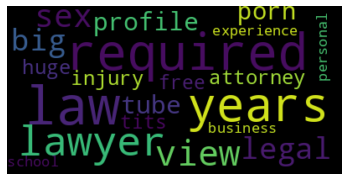

Adult Topic Id = 7


In [18]:
# create a wordcloud for topic: adult content


# get the top topic for a known adult content document 
docTopTopics = [maxTop(x) for x in ldamodelnormal.get_document_topics(corpus)]
adultTopicId = docTopTopics[15]


#gather most relevant terms for the given topic
topics_terms = ldamodelnormal.state.get_lambda()
tmpDict = {}
for i in range(1, len(topics_terms[0])):
    tmpDict[ldamodelnormal.id2word[i]]=topics_terms[adultTopicId,i]


# draw the wordcloud
wordcloud = WordCloud( margin=0,max_words=20 ).generate_from_frequencies(tmpDict)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
print("Adult Topic Id = " + str(adultTopicId))

In [19]:
# inspect regular topics - ATTENTION: ALL TOPICS ARE SHIFTED WITH ID +1 w.r.t. GENSIM
normalv

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.022398 -0.057067       1        1   4.093176
1      0.062898  0.003100       2        1   8.271734
2     -0.038283  0.027313       3        1   7.652333
3     -0.037483  0.035701       4        1  13.628231
4     -0.083630 -0.021532       5        1   8.952343
5      0.014266 -0.005650       6        1   2.926663
6     -0.010159  0.040611       7        1   3.928456
7     -0.024621  0.022241       8        1   3.311725
8     -0.034279  0.025837       9        1   4.041657
9      0.153347  0.015512      10        1  14.698612
10    -0.024197 -0.086517      11        1   5.715744
11     0.087730  0.018150      12        1   4.187456
12    -0.057950  0.059306      13        1   5.664486
13    -0.017449  0.000846      14        1  10.992847
14    -0.012587 -0.077851      15        1   1.934541, topic_info=      Category         Freq        Term        Total  loglift  logprob
11676  Default  5185.000000  architects  5185.000000  30.0000  30.0000
10371  Default  3828.000000        temp  3828.000000  29.0000  29.0000
9200   Default  2300.000000         max  2300.000000  28.0000  28.0000
528    Default  2281.000000         min  2281.000000  27.0000  27.0000
281    Default  6012.000000    download  6012.000000  26.0000  26.0000
...        ...          ...         ...          ...      ...      ...
1526   Topic15   159.030899        care  3200.539062   0.9433  -5.9732
1209   Topic15   102.816811       floor   500.858826   2.3619  -6.4093
1792   Topic15   111.776077     million  1085.343018   1.6721  -6.3258
875    Topic15   122.748978        view  4462.510254   0.3520  -6.2322
849    Topic15   114.761574         two  4218.254395   0.3410  -6.2994

[1153 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
12427      1  0.010907   039
12427      2  0.643525   039
12427      3  0.010907   039
12427      4  0.032722   039
12427      5  0.010907   039
...      ...       ...   ...
2044      11  0.030291  york
2044      12  0.012039  york
2044      13  0.067183  york
2044      14  0.055921  york
2044      15  0.020194  york

[12165 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [20]:
#inspect first 20 documents and their topic distributions
pd.set_option('display.max_colwidth', -1)
pd.concat([result['Target-URI'], dfnormal], axis=1).iloc[0:20]


,Target-URI,9,0,4,10,13,7,2,5,11,1,3,8,12,14,6
0,https://www.spiedigitallibrary.org/journals/journal-of-biomedical-optics/volume-22/issue-02/027003/Enzyme-functionalized-thin-cladding-long-period-fiber-grating-in-transition/10.1117/1.JBO.22.2.027003.full,0.998103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://redcliffssecondarycareers.com/?page=early-entry,NaN,0.288473,0.036896,0.386008,0.286887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.kink.com/shoot/40316,NaN,NaN,NaN,0.114019,NaN,0.882789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,http://ducknetweb.blogspot.com/2014/09/aarp-creates-new-tablet-for-seniors.html,0.050194,NaN,NaN,NaN,0.102360,NaN,0.828881,0.011495,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://www.umassmed.edu/cttc/,0.315405,0.021755,NaN,NaN,0.647727,NaN,NaN,NaN,0.013232,NaN,NaN,NaN,NaN,NaN,NaN
5,https://ju.se/en/it-helpdesk/faq---manuals.html,NaN,NaN,NaN,0.550520,NaN,NaN,NaN,0.153653,NaN,0.292661,NaN,NaN,NaN,NaN,NaN
6,https://www.jobs.ac.uk/job/AXS985/research-associate-78443-037/,NaN,0.632492,NaN,0.355288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,http://www.mathdepartment.net/Butte-College-math-department.php,NaN,0.561688,0.437678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,https://collections.ushmm.org/search/catalog/irn1003631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.449649,NaN,0.550298,NaN,NaN,NaN,NaN
9,http://mdciedu.com/news/british-masters-in-business-administration-mba-degree-final-applications-being-received-al-khobar-monday-16th-february-2015/,NaN,NaN,0.124483,0.601401,NaN,NaN,0.040911,0.042647,NaN,NaN,NaN,0.188535,NaN,NaN,NaN


### Aufgabe 1.1

In [108]:
topic_names = {
  0: 'Research',
  1: 'File Sharing',
  2: 'Blog & Forum',
  3: 'People & Life',
  4: 'School',
  5: 'Tech',
  6: 'Local',
  7: 'Adult Content',
  8: 'Geography',
  9: 'Nuclear/Medicine Research',
  10: 'Student',
  11: 'Environmental Research',
  12: 'Travel',
  13: 'Business',
  14: 'Weather',
}

## Aufgabe 1.2

Adult Content TopicID : 7

In [27]:
dfnormal

,9,0,4,10,13,7,2,5,11,1,3,8,12,14,6
0,0.998103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.288473,0.036896,0.386008,0.286887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,0.114019,NaN,0.882789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.050194,NaN,NaN,NaN,0.102360,NaN,0.828881,0.011495,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.315405,0.021755,NaN,NaN,0.647727,NaN,NaN,NaN,0.013232,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2686,NaN,NaN,NaN,NaN,NaN,0.343499,0.655399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2687,NaN,NaN,0.948132,NaN,NaN,NaN,NaN,0.050006,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2688,NaN,NaN,0.693616,NaN,NaN,NaN,0.120138,0.023511,NaN,NaN,0.161342,NaN,NaN,NaN,NaN
2689,NaN,NaN,0.729582,NaN,NaN,NaN,0.079134,NaN,0.141076,NaN,0.049006,NaN,NaN,NaN,NaN


In [28]:
pd.set_option('display.max_colwidth', -1)
docTopicTable = pd.concat([result['Target-URI'], dfnormal], axis=1)
docTopicTable

,Target-URI,9,0,4,10,13,7,2,5,11,1,3,8,12,14,6
0,https://www.spiedigitallibrary.org/journals/journal-of-biomedical-optics/volume-22/issue-02/027003/Enzyme-functionalized-thin-cladding-long-period-fiber-grating-in-transition/10.1117/1.JBO.22.2.027003.full,0.998103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://redcliffssecondarycareers.com/?page=early-entry,NaN,0.288473,0.036896,0.386008,0.286887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.kink.com/shoot/40316,NaN,NaN,NaN,0.114019,NaN,0.882789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,http://ducknetweb.blogspot.com/2014/09/aarp-creates-new-tablet-for-seniors.html,0.050194,NaN,NaN,NaN,0.102360,NaN,0.828881,0.011495,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://www.umassmed.edu/cttc/,0.315405,0.021755,NaN,NaN,0.647727,NaN,NaN,NaN,0.013232,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2686,https://eros.ws/watch-me-cum-ktee-marie/2018-04-16/,NaN,NaN,NaN,NaN,NaN,0.343499,0.655399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2687,https://www.mariner-sails.com/yak-gear-handle-rubber-tipped-2-hole.html,NaN,NaN,0.948132,NaN,NaN,NaN,NaN,0.050006,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2688,http://skibanter.com/forumdisplay.php?s=b0b4e4860f94f6cbf4aba2800ab16796&f=6&daysprune=-1&order=desc&sort=views,NaN,NaN,0.693616,NaN,NaN,NaN,0.120138,0.023511,NaN,NaN,0.161342,NaN,NaN,NaN,NaN
2689,http://youth.worldbridge.org/2018-wbf-yotc-solver-problem-no9-by-ilai-baniri-fernando-lema/,NaN,NaN,0.729582,NaN,NaN,NaN,0.079134,NaN,0.141076,NaN,0.049006,NaN,NaN,NaN,NaN


In [30]:
docTopicTableFiltered = docTopicTable[(docTopicTable[7] < 0.5) | (docTopicTable[7].isna())]
docTopicTableFiltered

,Target-URI,9,0,4,10,13,7,2,5,11,1,3,8,12,14,6
0,https://www.spiedigitallibrary.org/journals/journal-of-biomedical-optics/volume-22/issue-02/027003/Enzyme-functionalized-thin-cladding-long-period-fiber-grating-in-transition/10.1117/1.JBO.22.2.027003.full,0.998103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://redcliffssecondarycareers.com/?page=early-entry,NaN,0.288473,0.036896,0.386008,0.286887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,http://ducknetweb.blogspot.com/2014/09/aarp-creates-new-tablet-for-seniors.html,0.050194,NaN,NaN,NaN,0.102360,NaN,0.828881,0.011495,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://www.umassmed.edu/cttc/,0.315405,0.021755,NaN,NaN,0.647727,NaN,NaN,NaN,0.013232,NaN,NaN,NaN,NaN,NaN,NaN
5,https://ju.se/en/it-helpdesk/faq---manuals.html,NaN,NaN,NaN,0.550520,NaN,NaN,NaN,0.153653,NaN,0.292661,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2686,https://eros.ws/watch-me-cum-ktee-marie/2018-04-16/,NaN,NaN,NaN,NaN,NaN,0.343499,0.655399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2687,https://www.mariner-sails.com/yak-gear-handle-rubber-tipped-2-hole.html,NaN,NaN,0.948132,NaN,NaN,NaN,NaN,0.050006,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2688,http://skibanter.com/forumdisplay.php?s=b0b4e4860f94f6cbf4aba2800ab16796&f=6&daysprune=-1&order=desc&sort=views,NaN,NaN,0.693616,NaN,NaN,NaN,0.120138,0.023511,NaN,NaN,0.161342,NaN,NaN,NaN,NaN
2689,http://youth.worldbridge.org/2018-wbf-yotc-solver-problem-no9-by-ilai-baniri-fernando-lema/,NaN,NaN,0.729582,NaN,NaN,NaN,0.079134,NaN,0.141076,NaN,0.049006,NaN,NaN,NaN,NaN


In [33]:
print(docTopicTable.size)
print(docTopicTableFiltered.size)

43056
41984


In [35]:
#Anzahl entfernter Dokumente
delta = docTopicTable.size - docTopicTableFiltered.size
print(delta)
print(delta/docTopicTable.size)

1072
0.02489780750650316


docTopicTableFiltered ist die gefilterte Tabelle. Aus der Differenz, zwischen dieser Tabelle und der originalen Tabelle, erhält man 1072, was heißt, dass 1072 Dokumente ausgefiltert wurden.

## Aufgabe 1.3

Bei der Aufgabe muss beachtet werden, dass die Topics bei 0 starten, während unsere Lookup-Tabelle bei 1 startet.


In [36]:
docTopicTableFiltered

,Target-URI,9,0,4,10,13,7,2,5,11,1,3,8,12,14,6
0,https://www.spiedigitallibrary.org/journals/journal-of-biomedical-optics/volume-22/issue-02/027003/Enzyme-functionalized-thin-cladding-long-period-fiber-grating-in-transition/10.1117/1.JBO.22.2.027003.full,0.998103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://redcliffssecondarycareers.com/?page=early-entry,NaN,0.288473,0.036896,0.386008,0.286887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,http://ducknetweb.blogspot.com/2014/09/aarp-creates-new-tablet-for-seniors.html,0.050194,NaN,NaN,NaN,0.102360,NaN,0.828881,0.011495,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://www.umassmed.edu/cttc/,0.315405,0.021755,NaN,NaN,0.647727,NaN,NaN,NaN,0.013232,NaN,NaN,NaN,NaN,NaN,NaN
5,https://ju.se/en/it-helpdesk/faq---manuals.html,NaN,NaN,NaN,0.550520,NaN,NaN,NaN,0.153653,NaN,0.292661,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2686,https://eros.ws/watch-me-cum-ktee-marie/2018-04-16/,NaN,NaN,NaN,NaN,NaN,0.343499,0.655399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2687,https://www.mariner-sails.com/yak-gear-handle-rubber-tipped-2-hole.html,NaN,NaN,0.948132,NaN,NaN,NaN,NaN,0.050006,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2688,http://skibanter.com/forumdisplay.php?s=b0b4e4860f94f6cbf4aba2800ab16796&f=6&daysprune=-1&order=desc&sort=views,NaN,NaN,0.693616,NaN,NaN,NaN,0.120138,0.023511,NaN,NaN,0.161342,NaN,NaN,NaN,NaN
2689,http://youth.worldbridge.org/2018-wbf-yotc-solver-problem-no9-by-ilai-baniri-fernando-lema/,NaN,NaN,0.729582,NaN,NaN,NaN,0.079134,NaN,0.141076,NaN,0.049006,NaN,NaN,NaN,NaN


In [253]:
def get_topic_from_loc(df, loc):
    d = df.loc[loc]
    s = d[1:].sort_values(ascending=False)
    url = d.values[0]
    p = np.round(s.values[0], 3)
    tid = s.index[0]
    tname = topic_names[tid]
    print(url)
    print(f'{tname} : {p}%')

In [84]:
get_topic_from_loc(docTopicTableFiltered, 3)

http://ducknetweb.blogspot.com/2014/09/aarp-creates-new-tablet-for-seniors.html
Forum : 0.829%


In [86]:
get_topic_from_loc(docTopicTableFiltered, 1510)

http://www.komu.com/news/demonstration-planned-at-st-louis-county-outlet-mall/page/2
School : 0.967%


Dokument 1510:

Das Dokument hat eine hohe Topicwahrscheinlichkeit zu Topic 5. Topic 5 hatte von uns als intuitiver Überbegriff Schools.

Beim Besuchen der Website erkennt man, dass es sich um ein Artikel auf eine News-Seite handelt. Der Artikel geht über eine geplannte Demonstration in einen Einkaufszentrum. 

Dies hat zunächst wenig mit dem Überbegriff zu tun. Wenn man sich aber die enzelne Terme des Topics anschaut, dann kann man mehrere Terme finden, die auch auf der Website verwendet werden (zb. "year", "day", "city", "events", etc.). 

Desweiteren, haben wir beim genaureren Anschauen der Website festgestellt, dass die Seite auf weitere Artikel verlinkt. Dabei gab es Artikel mit Themen, die dem Überbegriff Schools übereinstimmen:

- Columbia teacher receives $25,000 educator award

- MU police arrest woman for having drugs in car with child 


In [89]:
get_topic_from_loc(docTopicTableFiltered, 251)

http://www.mkweddingphotography.com/warwickshire-wedding-photographer/
Life : 0.996%


Dokument 251:

Das Dokument hat eine hohe Topicwahrscheinlichkeit zu Topic 4. Topic 4 hatte von uns als intuitiver Überbegriff Travel, People & Life.

Die Website selbst handelt um eine Person, die Fotos für Hochzeiten schießt, was zum Überbegriff People & Life passen würde.

## Aufgabe 1.4

In [91]:
df = docTopicTable

In [109]:
def topics_by_p(df, tid1, p1, tid2, p2):
    dff = df[(df[tid1] > p1) & (df[tid2] > p2)]
    print(f'Topic 1: {topic_names[tid1]}, {p1}%')
    print(f'Topic 2: {topic_names[tid2]}, {p2}%')
    return(dff)

In [110]:
dff = topics_by_p(df, 9, 0.3, 11, 0.3)
dff['Target-URI']

Topic 1: Nuclear/Medicine Research, 0.3%
Topic 2: Environmental Research, 0.3%


1640    https://www.omicsonline.org/peer-reviewed/underlying-the-mechanism-of-5fluorouracil-and-human-serum-albumininteraction-a-biophysical-study-70785.html
Name: Target-URI, dtype: object

Die gefilterte Tabelle soll eine Wahrscheinlichkeit von über 30% haben zu den Topics 10 & 12. Diese haben als Überbegriffe "Nuclear/Medicine Research" und "Environmental Research". Deswegen würden wir als Ergebnis irgendwas mit Forschung in diesen Richtungen erwarten. Wir bekommen medizinische Forschung. Passt.

In [111]:
dff = topics_by_p(df, 3, 0.3, 14, 0.3)
dff['Target-URI']

Topic 1: People & Life, 0.3%
Topic 2: Weather, 0.3%


147     http://allisonpanter.liveurbandenver.com/about-me.php                                           
1317    https://mysunshinecoast.com.au/business/category/tourism-hospitality-business-sales-brokers,2706
Name: Target-URI, dtype: object

Die gefilterte Tabelle soll eine Wahrscheinlichkeit von über 30% haben zu den Topics 4 & 15. Diese haben als Überbegriffe "Life & People" und "Weather". Deswegen würden wir als Ergebnis erwarten, dass die Dokumente über Travel gehen.

Dokument 1317:
    
Die Website handelt über Tourismus und Business Sales an Küstenstädten, was der Topic 4 zusprechen würde. Zudem beinhaltet der Name der Website/Unternehmens das Wort "sunshine", welches auf das Überbegriff "Weather" zutrifft. Der Name  wurde auf dieser Website 36 mal verwendet, wodurch sich auch diese Topicwahrscheinlichkeit erklären lässt.

## Aufgabe 1.5

"The alpha controls the mixture of topics for any given document. Turn it down, and the documents will likely have less of a mixture of topics. Turn it up, and the documents will likely have more of a mixture of topics."

[src](https://medium.com/@lettier/how-does-lda-work-ill-explain-using-emoji-108abf40fa7d)

In [113]:
def model_by_alpha(alpha):
    new_ldamodelnormal = gensim.models.ldamodel.LdaModel(corpus, num_topics=15, id2word = dictionary, passes=10, chunksize=100, update_every=0, alpha=alpha, random_state=1)
    new_normalv, new_dfnormal = getModelResults(new_ldamodelnormal, corpus, dictionary)
    return(new_ldamodelnormal, new_normalv, new_dfnormal)

### Alpha = 1

In [114]:
lda1, lv1, df1 = model_by_alpha(1)

/home/max/minimamba/envs/twm/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [115]:
lda1

In [116]:
lv1

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.014544 -0.066425  1       1        6.262956 
1     -0.067669  0.005181  2       1        8.268583 
2      0.025683  0.034882  3       1        6.745765 
3      0.034566  0.051133  4       1        14.268647
4      0.090016 -0.015033  5       1        8.812187 
5     -0.014811 -0.000837  6       1        2.091109 
6      0.007731  0.025891  7       1        4.172239 
7     -0.011631  0.045999  8       1        4.451283 
8      0.024516 -0.020250  9       1        2.943727 
9     -0.155253  0.007495  10      1        15.339332
10     0.035215 -0.086328  11      1        5.377888 
11    -0.037651 -0.022958  12      1        3.052545 
12     0.044298  0.052934  13      1        5.124817 
13     0.021624  0.026083  14      1        11.211735
14     0.017909 -0.037767  15      1        1.877192 , topic_info=      Category         Freq          Term        Total  loglift  logprob
11676  Default  5382.000000  architects    5382.000000  30.0000  30.0000
10371  Default  3712.000000  temp          3712.000000  29.0000  29.0000
9200   Default  2227.000000  max           2227.000000  28.0000  28.0000
528    Default  2209.000000  min           2209.000000  27.0000  27.0000
695    Default  4051.000000  report        4051.000000  26.0000  26.0000
...        ...          ...     ...                ...      ...      ...
1209   Topic15  95.975960    floor         503.941223   2.3170  -6.4481 
3052   Topic15  105.226830   construction  930.157349   1.7962  -6.3561 
1792   Topic15  106.309692   million       1085.823975  1.6517  -6.3459 
849    Topic15  112.001923   two           4219.270996  0.3465  -6.2937 
875    Topic15  112.150139   view          4542.552734  0.2740  -6.2924 

[1158 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
12427  1      0.010765  039 
12427  2      0.645880  039 
12427  3      0.010765  039 
12427  4      0.032294  039 
12427  5      0.010765  039 
...   ..           ...  ... 
2044   11     0.029344  york
2044   12     0.013302  york
2044   13     0.057905  york
2044   14     0.055557  york
2044   15     0.019562  york

[12560 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

In [128]:
df1.head(10) # alpha = 1

,9,0,3,4,10,13,2,7,12,6,11,1,5,8,14
0,0.978410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.011255,0.612487,0.011433,0.039802,0.231091,0.037203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,0.071777,0.134602,NaN,0.027063,0.717694,0.010008,NaN,NaN,NaN,NaN,NaN,NaN
3,0.031705,NaN,0.038273,NaN,NaN,0.080651,0.812804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.273893,0.273124,NaN,0.019940,0.011843,0.105310,NaN,0.015907,NaN,0.014532,0.244003,NaN,NaN,NaN,NaN
5,NaN,0.520722,NaN,0.011138,0.232884,NaN,0.010856,NaN,NaN,NaN,0.010975,0.058225,0.091200,0.014581,NaN
6,0.016071,0.667600,0.024829,0.021266,0.060150,0.020380,0.022043,0.019875,0.017128,0.020550,0.017644,0.021662,0.021437,0.031905,0.01746
7,NaN,0.664694,NaN,0.313371,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.997159,NaN,NaN,NaN,NaN
9,NaN,0.275687,0.011091,0.074374,0.339583,0.019989,0.043015,NaN,NaN,NaN,NaN,0.013072,0.015648,0.170254,NaN


In [130]:
dfnormal.head(10) # alpha = 1/15

,9,0,4,10,13,7,2,5,11,1,3,8,12,14,6
0,0.998103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.288473,0.036896,0.386008,0.286887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,0.114019,NaN,0.882789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.050194,NaN,NaN,NaN,0.102360,NaN,0.828881,0.011495,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.315405,0.021755,NaN,NaN,0.647727,NaN,NaN,NaN,0.013232,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,0.550520,NaN,NaN,NaN,0.153653,NaN,0.292661,NaN,NaN,NaN,NaN,NaN
6,NaN,0.632492,NaN,0.355288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,0.561688,0.437678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.449649,NaN,0.550298,NaN,NaN,NaN,NaN
9,NaN,NaN,0.124483,0.601401,NaN,NaN,0.040911,0.042647,NaN,NaN,NaN,0.188535,NaN,NaN,NaN


### Alpha = 10^-18

In [125]:
alpha = 10 ** -18
lda2, lv2, df2 = model_by_alpha(alpha)

/home/max/minimamba/envs/twm/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [132]:
df2.head(10) # alpha = 10 ** -18

,9,0,4,10,13,7,2,5,1,3,11,8,14,12,6
0,0.998748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.263664,0.032045,0.383000,0.321291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,0.110866,NaN,0.889134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.050643,NaN,NaN,NaN,0.102955,NaN,0.829827,0.011820,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.319290,NaN,NaN,NaN,0.679433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,0.551077,NaN,NaN,NaN,0.144561,0.304361,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,0.620412,NaN,0.379588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,0.561740,0.438260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.694105,0.305895,NaN,NaN,NaN,NaN
9,NaN,NaN,0.121568,0.605598,NaN,NaN,0.038027,0.039878,NaN,NaN,NaN,0.188161,NaN,NaN,NaN


In [133]:
dfnormal.head(10) # alpha = 1/15

,9,0,4,10,13,7,2,5,11,1,3,8,12,14,6
0,0.998103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.288473,0.036896,0.386008,0.286887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,0.114019,NaN,0.882789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.050194,NaN,NaN,NaN,0.102360,NaN,0.828881,0.011495,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.315405,0.021755,NaN,NaN,0.647727,NaN,NaN,NaN,0.013232,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,0.550520,NaN,NaN,NaN,0.153653,NaN,0.292661,NaN,NaN,NaN,NaN,NaN
6,NaN,0.632492,NaN,0.355288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,0.561688,0.437678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.449649,NaN,0.550298,NaN,NaN,NaN,NaN
9,NaN,NaN,0.124483,0.601401,NaN,NaN,0.040911,0.042647,NaN,NaN,NaN,0.188535,NaN,NaN,NaN


# 2. Topic Model on NHTSA (Using HANA Text Analysis Index Table)
## 2.1  Constructing the Corpus (Using HANA Text Analysis Index Table) and Building the Model

In [302]:
#data ingestion and filtering

cmpl = pd.read_csv("./NHTSA_HANA/cmpl.csv", header=None,  keep_default_na=False)
ta = pd.read_csv("./NHTSA_HANA/data.csv", header=None,  keep_default_na=False)

ta.columns = ["CMPLID", "TA_RULE","TA_COUNTER","TA_TOKEN","TA_LANGUAGE","TA_TYPE","TA_TYPE_EXPANDED",
              "TA_NORMALIZED" ,"TA_STEM","TA_PARAGRAPH","TA_SENTENCE","TA_CREATED_AT","TA_OFFSET","TA_PARENT" ]
cmpl.columns = ["CMPLID", "ODINO", "MFR_NAME", "MAKETEXT", "MODELTXT", "YEARTXT", "CRASH", "FAILDATE", "FIRE", "INJURED", "DEATHS", "COMPDESC", "CITY", "STATE", "VIN", "DATEA", "LDATE", "MILES", "OCCURRENCES", "CDESCR", "CMPL_TYPE", "POLICE_RPT_VN", "PURCH_DT", "ORIG_OWNER_YN", "ANTI_BRAKES_YN", "CRUISE_CONT_YN", "NUM_CYLS", "DRIVE_TRAIN", "FUEL_SYS", "FUEL_TYPE", "TRANS_TYPE", "VEH_SPEED", "DOT", "TIRE_SIZE", "LOC_OF_TIRE", "TIRE_FAIL_TYPE", "ORIG_EQUIP_YN", "MANUF_DT", "SEAT_TYPE", "RESTRAINT_TYPE", "DEALER_NAME", "DEALER_TEL", "DEALER_CITY", "DEALER_STATE", "DEALER_ZIP", "PROD_TYPE", "REPAIRED_YN", "MEDICAL_ATTN", "VEHICELS_TOWED_YN"]


In [303]:
#filtering and aggregation

ta = ta[ta.TA_TYPE.isin(['noun', 'adjective']) ]
ta.TA_TOKEN = ta.TA_TOKEN.str.lower()
ta = ta[~ta.TA_TOKEN.isin(['car', 'vehicle']) ] #use as additional stop words
cmpl = cmpl[cmpl.COMPDESC.isin([ 'AIR BAGS','VISIBILITY/WIPER','EXTERIOR LIGHTING','FUEL/PROPULSION SYSTEM', 'SERVICE BRAKES','WHEELS']) ]

ta = ta.merge(cmpl.loc[:,'CMPLID'], on=['CMPLID'], how='inner')
tagrouped = ta.groupby('CMPLID')['TA_TOKEN'].apply(list)

In [304]:
#show category counts
relevantComplaints = cmpl[cmpl.CMPLID.isin(tagrouped.index.tolist())].sort_values(by=['CMPLID'])
counter=collections.Counter(relevantComplaints.COMPDESC)
print(counter)
print("Anzahl Dokumente: " + str(len(relevantComplaints)))

Counter({'SERVICE BRAKES': 2932, 'AIR BAGS': 2638, 'FUEL/PROPULSION SYSTEM': 1788, 'EXTERIOR LIGHTING': 1323, 'VISIBILITY/WIPER': 1175, 'WHEELS': 1157})
Anzahl Dokumente: 11013


In [305]:
#create gensim data structure
nhtsadic = corpora.Dictionary(tagrouped.tolist())
nhtsadic.filter_extremes(no_below=10, no_above=0.4)
nhtsadic.compactify()
nhtsacorpus = [nhtsadic.doc2bow(text) for text in tagrouped]

In [306]:
%%time

#build topic model and create descriptive stuff
nhtsalda = LdaMulticore(nhtsacorpus, num_topics=10, id2word = nhtsadic, passes=20, alpha=0.0000001, random_state=1)
nhtsavis, dfnhtsa = getModelResults(nhtsalda, nhtsacorpus, nhtsadic)

/home/max/minimamba/envs/twm/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


CPU times: user 33 s, sys: 8.84 s, total: 41.8 s
Wall time: 57.2 s


## 2.1 Inspecting the Results

In [307]:
nhtsavis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.124534 -0.136050  1       1        9.418118 
1      0.000515 -0.005235  2       1        7.973995 
2      0.031857  0.122694  3       1        7.858251 
3     -0.000047 -0.025681  4       1        12.838049
4      0.052764  0.020294  5       1        6.272768 
5      0.056113  0.119335  6       1        15.503582
6      0.001231  0.137171  7       1        5.873278 
7     -0.002479 -0.095051  8       1        12.540610
8      0.078816 -0.100285  9       1        8.144472 
9     -0.343303 -0.037192  10      1        13.576886, topic_info=    Category         Freq        Term        Total  loglift  logprob
780  Default  4722.000000  contact     4722.000000  30.0000  30.0000
27   Default  4133.000000  failure     4133.000000  29.0000  29.0000
241  Default  4390.000000  brake       4390.000000  28.0000  28.0000
597  Default  1589.000000  windshield  1589.000000  27.0000  27.0000
51   Default  3061.000000  brakes      3061.000000  26.0000  26.0000
..       ...          ...     ...              ...      ...      ...
241  Topic10  390.638000   brake       4390.529297 -0.4226  -4.6567 
111  Topic10  322.831360   front       2683.629395 -0.1210  -4.8474 
25   Topic10  295.898621   passenger   1847.150879  0.1654  -4.9345 
54   Topic10  264.461548   warning     952.987183   0.7149  -5.0468 
132  Topic10  271.962677   time        2743.521973 -0.3145  -5.0189 

[693 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1272  4      0.035336  01     
1272  10     0.918729  01     
1796  8      0.036611  03     
1796  10     0.951877  03     
1273  10     0.961206  04     
...   ..          ...  ..     
297   7      0.113011  year   
297   8      0.151354  year   
297   9      0.092831  year   
297   10     0.002018  year   
1880  9      0.974270  youtube

[2699 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [418]:
for words in nhtsalda.print_topics(num_words=8):
    print(words)

(0, '0.030*"headlights" + 0.024*"night" + 0.023*"lights" + 0.015*"road" + 0.015*"light" + 0.015*"side" + 0.011*"safety" + 0.011*"low"')
(1, '0.042*"wheel" + 0.021*"steering" + 0.018*"light" + 0.017*"dealership" + 0.014*"dealer" + 0.014*"problem" + 0.013*"front" + 0.013*"time"')
(2, '0.089*"brake" + 0.060*"brakes" + 0.029*"parking" + 0.025*"pedal" + 0.018*"front" + 0.017*"noise" + 0.015*"foot" + 0.012*"rear"')
(3, '0.038*"recall" + 0.024*"issue" + 0.021*"consumer" + 0.021*"dealer" + 0.018*"dealership" + 0.018*"problem" + 0.016*"safety" + 0.015*"service"')
(4, '0.047*"lights" + 0.030*"trailer" + 0.029*"brake" + 0.028*"light" + 0.021*"system" + 0.019*"brakes" + 0.017*"dealer" + 0.015*"issue"')
(5, '0.024*"engine" + 0.021*"truck" + 0.020*"stop" + 0.017*"brakes" + 0.017*"light" + 0.016*"traffic" + 0.015*"miles" + 0.015*"power"')
(6, '0.056*"fuel" + 0.037*"gas" + 0.033*"brake" + 0.028*"tank" + 0.021*"miles" + 0.020*"fluid" + 0.019*"dealer" + 0.018*"time"')
(7, '0.044*"tires" + 0.042*"tire" +

In [467]:
nhtsa_names = {
    0: 'Lights',
    1: 'Steering Wheel',
    2: 'Brakes',
    3: 'Recall',
    4: 'Light & Brakes',
    5: 'Engine',
    6: 'Fuel',
    7: 'Tires',
    8: 'Windshield',
    9: 'Contact Requests'
}

In [440]:
# add url to dataframe and inspect
pd.set_option('display.max_colwidth', -1)
df_cars = pd.concat([pd.DataFrame(tagrouped.index), dfnhtsa], axis=1)

In [441]:
df_cars

,CMPLID,6,7,8,0,1,9,3,4,2,5
0,10661,0.135776,0.613206,0.251018,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12434,NaN,0.344732,NaN,0.348404,0.306863,NaN,NaN,NaN,NaN,NaN
2,14609,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,18695,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,23755,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
11008,1478390,NaN,NaN,NaN,NaN,0.258270,0.74173,NaN,NaN,NaN,NaN
11009,1478409,NaN,NaN,NaN,NaN,NaN,NaN,0.999999,NaN,NaN,NaN
11010,1478410,NaN,NaN,0.534148,NaN,NaN,NaN,NaN,NaN,NaN,0.465852
11011,1478432,NaN,NaN,NaN,0.900461,NaN,NaN,NaN,0.099539,NaN,NaN


In [530]:
df_cars.sort_values(by=9, ascending=False)

,COMPDESC,CMPLID,6,7,8,0,1,9,3,4,2,5,topic
4892,FUEL/PROPULSION SYSTEM,1345874,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,9
2355,AIR BAGS,1264345,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,9
7529,AIR BAGS,1413318,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,9
7506,AIR BAGS,1412878,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,9
7505,SERVICE BRAKES,1412877,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11007,AIR BAGS,1478383,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
11009,AIR BAGS,1478409,NaN,NaN,NaN,NaN,NaN,NaN,0.999999,NaN,NaN,NaN,3
11010,VISIBILITY/WIPER,1478410,NaN,NaN,0.534148,NaN,NaN,NaN,NaN,NaN,NaN,0.465852,8
11011,EXTERIOR LIGHTING,1478432,NaN,NaN,NaN,0.900461,NaN,NaN,NaN,0.099539,NaN,NaN,0


In [523]:
get_desc_from_id(df_cars, 1478436)

WHILE WAITING IN TRAFFIC ON A COUNTY ROAD TO TURN LEFT\, OUR SIENNA WAS HIT FROM BEHIND BY A CAR TRAVELING AT APPROXIMATELY 40 MPH. FRONT ROW SEATBELTS DID NOT ENGAGE\, NOR DID FRONT AIRBAGS DEPLOY.  OUR SIENNA HIT THE STOPPED VEHICLE IN FRONT OF US UPON IMPACT AS WELL. ONLY RIGHT SIDE CURTAIN AIRBAGS DEPLOYED AND MIDDLE ROW SEATBELTS RESTRAIN.  THIS RESULTED IN MULTIPLE INJURIES TO THE FRONT ROW PASSENGERS\, INCLUDING A SEVERE CONCUSSION.
Fuel : 1478436


In [445]:
def get_desc_from_id(df, cmplid):
    d = df[df['CMPLID'] == cmplid]
    s = pd.Series(d.values[0][1:])
    fix = {0:6, 1:7, 2:8, 3:0, 4:1, 5:9, 6:3, 7:4, 8:2, 9:5}
    s = s.sort_values(ascending=False)
    p = np.round(s.values[0], 3)
    tid = fix[s.index[0]]
    tname = nhtsa_names[tid]
    desc = cmpl[cmpl.CMPLID == cmplid]['CDESCR'].values[0]
    print(desc)
    print(f'{tname} : {p}')

## 2.2 Hardclustering

In [493]:
def get_best_topic(row):
    s = row[1:].sort_values(ascending=False)
    tid = s.index[0]
    return(tid)

In [495]:
df_cars['topic'] = df_cars.apply(lambda row: get_best_topic(row), axis=1)

In [496]:
df_cars.head()

,CMPLID,6,7,8,0,1,9,3,4,2,5,topic
0,10661,0.135776,0.613206,0.251018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
1,12434,NaN,0.344732,NaN,0.348404,0.306863,NaN,NaN,NaN,NaN,NaN,0
2,14609,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
3,18695,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
4,23755,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,1


In [498]:
doc_cats = list(cmpl['COMPDESC'].drop_duplicates())
doc_cats

['SERVICE BRAKES',
 'AIR BAGS',
 'WHEELS',
 'EXTERIOR LIGHTING',
 'FUEL/PROPULSION SYSTEM',
 'VISIBILITY/WIPER']

In [519]:
df_cars = pd.concat([relevantComplaints.reset_index()['COMPDESC'], df_cars], axis=1)
df_cars.head()

,COMPDESC,CMPLID,6,7,8,0,1,9,3,4,2,5,topic
0,WHEELS,10661,0.135776,0.613206,0.251018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
1,WHEELS,12434,NaN,0.344732,NaN,0.348404,0.306863,NaN,NaN,NaN,NaN,NaN,0
2,AIR BAGS,14609,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
3,AIR BAGS,18695,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
4,WHEELS,23755,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,1


In [681]:
comp = {
    'SERVICE BRAKES' : [2, 4],
    'AIR BAGS' : [1, 3, 4, 7, 9],
    'WHEELS' : [7],
    'EXTERIOR LIGHTING' : [0, 4],
    'FUEL/PROPULSION SYSTEM' : [5,6],
    'VISIBILITY/WIPER' : [8]
}

In [533]:
df_cars.iloc[2]

COMPDESC    AIR BAGS
CMPLID      14609   
6           NaN     
7           NaN     
8           1       
0           NaN     
1           NaN     
9           NaN     
3           NaN     
4           NaN     
2           NaN     
5           NaN     
topic       8       
Name: 2, dtype: object

In [537]:
def match_check(row):
    desc = row['COMPDESC']
    targets = comp[desc]
    tid = row['topic']
    check = tid in targets
    return(int(check))

In [682]:
df_check = df_cars.apply(lambda row: match_check(row), axis=1)
n = len(df_check)
t = len(df_check[df_check == 1])
acc = t/n

In [683]:
print(acc)

0.5828566239898302


### 2.3

In [676]:
def mapx(row):
    l = [0] * 10
    l[row['topic']] = 1
    names = ['COMPDESC'] + list(range(10))
    s = pd.Series([row['COMPDESC']] + l, index=names)
    return(s)

In [677]:
xtable = df_cars[['COMPDESC'] + list(range(10)) + ['topic']]
xtable = xtable.apply(lambda row: mapx(row), axis=1)
xtable = xtable.groupby('COMPDESC').sum()

In [678]:
xtable

,0,1,2,3,4,5,6,7,8,9
COMPDESC,,,,,,,,,,
AIR BAGS,11,210,53,590,63,94,37,788,62,730
EXTERIOR LIGHTING,748,38,15,92,207,38,26,24,26,109
FUEL/PROPULSION SYSTEM,13,76,42,348,29,728,317,26,31,178
SERVICE BRAKES,54,165,630,231,263,755,171,85,67,511
VISIBILITY/WIPER,239,18,10,47,21,19,10,116,584,111
WHEELS,20,269,31,100,6,43,21,561,13,93


In [ ]:
xtable

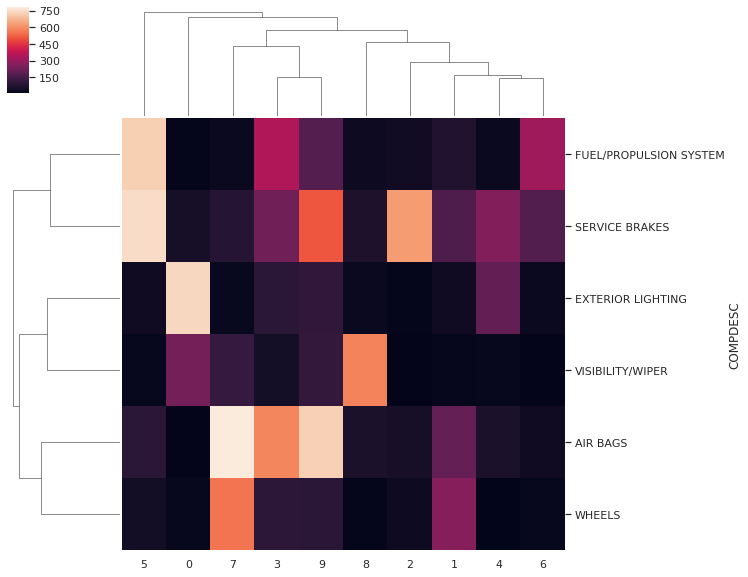

In [680]:
import seaborn as sns; sns.set(color_codes=True)
sns.clustermap(xtable)

In [684]:
comp = {
    'SERVICE BRAKES' : [5, 9, 2, 4],
    'AIR BAGS' : [1, 3, 7, 9],
    'WHEELS' : [7,1],
    'EXTERIOR LIGHTING' : [0, 4],
    'FUEL/PROPULSION SYSTEM' : [5,3,6],
    'VISIBILITY/WIPER' : [0, 8]
}
df_check = df_cars.apply(lambda row: match_check(row), axis=1)
n = len(df_check)
t = len(df_check[df_check == 1])
acc = t/n
print(acc)

0.7698174884227731


# 3. Topics auf Wiki

In [208]:
names = ['id', 'cat', 'title', 'url', 'text']
df_wiki = pd.read_csv('wiki.csv', header=None, names=names, escapechar='\\', encoding='latin_1')

In [209]:
df = df_wiki

In [166]:
df.head(5)

id   cat                        title  \
0  2125  Dogs  Dog fighting                  
1  2126  Dogs  Dog behaviourist              
2  2127  Dogs  Animal nutritionist           
3  2128  Dogs  World's Ugliest Dog Contest   
4  2833  Fish  Amphiperca                    

                                                           url  \
0  https://en.wikipedia.org/wiki/Dog_fighting                    
1  https://en.wikipedia.org/wiki/Dog_behaviourist                
2  https://en.wikipedia.org/wiki/Animal_nutritionist             
3  https://en.wikipedia.org/wiki/World%27s_Ugliest_Dog_Contest   
4  https://en.wikipedia.org/wiki/Amphiperca                      

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [226]:
df[df.id == 5008]

,id,cat,title,url,text
538,5008,Video_games,Book:Space Invaders series,https://en.wikipedia.org/wiki/Book:Space_Invaders_series,NaN


In [224]:
df.shape

(5660, 5)

In [227]:
df_clean = df.dropna()

In [228]:
df_clean.shape

(5656, 5)

In [231]:
#auxiliary function for "straight-forward" natural language preprocessing

def cleanup_text_wiki(record):
    text = record['text']
    # Remove newlines
    text = text.replace(r'\n', ' ')
    words = text.split()

    # Default list of Stopwords
    stopwords_core = ['a', u'about', u'above', u'after', u'again', u'against', u'all', u'am', u'an', u'and', u'any',
                      u'are', u'arent', u'as', u'at',
                      u'be', u'because', u'been', u'before', u'being', u'below', u'between', u'both', u'but', u'by',
                      u'can', 'cant', 'come', u'could', 'couldnt',
                      u'd', u'did', u'didn', u'do', u'does', u'doesnt', u'doing', u'dont', u'down', u'during',
                      u'each',
                      u'few', 'finally', u'for', u'from', u'further',
                      u'had', u'hadnt', u'has', u'hasnt', u'have', u'havent', u'having', u'he', u'her', u'here',
                      u'hers', u'herself', u'him', u'himself', u'his', u'how',
                      u'i', u'if', u'in', u'into', u'is', u'isnt', u'it', u'its', u'itself',
                      u'just',
                      u'll',
                      u'm', u'me', u'might', u'more', u'most', u'must', u'my', u'myself',
                      u'no', u'nor', u'not', u'now',
                      u'o', u'of', u'off', u'on', u'once', u'only', u'or', u'other', u'our', u'ours', u'ourselves',
                      u'out', u'over', u'own',
                      u'r', u're',
                      u's', 'said', u'same', u'she', u'should', u'shouldnt', u'so', u'some', u'such',
                      u't', u'than', u'that', 'thats', u'the', u'their', u'theirs', u'them', u'themselves', u'then',
                      u'there', u'these', u'they', u'this', u'those', u'through', u'to', u'too',
                      u'under', u'until', u'up',
                      u'very',
                      u'was', u'wasnt', u'we', u'were', u'werent', u'what', u'when', u'where', u'which', u'while',
                      u'who', u'whom', u'why', u'will', u'with', u'wont', u'would',
                      u'y', u'you', u'your', u'yours', u'yourself', u'yourselves']

    # Custom List of Stopwords - Add your own here
    stopwords_custom = ['']
    stopwords = stopwords_core + stopwords_custom
    stopwords = [word.lower() for word in stopwords]

    text_out = [re.sub('[^a-zA-Z0-9]', '', word) for word in words]  # Remove special characters
    text_out = [word.lower() for word in text_out if
                len(word) > 2 and word.lower() not in stopwords]  # Remove stopwords and words under X length
    return text_out

In [232]:
%%time
#build gensim corpus
result = df_clean
result=result.reset_index()
texts=[]
for index, row in result.iterrows():
    texts.append(cleanup_text_wiki(row))

dictionary_wiki = corpora.Dictionary(texts)
dictionary_wiki.filter_extremes(no_below=10, no_above=0.4)
dictionary_wiki.compactify()
corpus_wiki = [dictionary_wiki.doc2bow(text) for text in texts]

CPU times: user 9.03 s, sys: 0 ns, total: 9.03 s
Wall time: 9.05 s


In [235]:
lda_wiki = gensim.models.ldamodel.LdaModel(corpus_wiki, num_topics=5, id2word = dictionary_wiki, passes=10, chunksize=100, update_every=0, alpha=1/15, random_state=1)

In [716]:
%%time
# get descriptive stuff for all models
vis_wiki, df_wiki_lda = getModelResults(lda_wiki, corpus_wiki, dictionary_wiki)

/home/max/minimamba/envs/twm/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


CPU times: user 14.1 s, sys: 22.3 s, total: 36.4 s
Wall time: 2min


In [237]:
df = df_wiki_lda

In [280]:
# add url to dataframe and inspect
pd.set_option('display.max_colwidth', -1)
df = pd.concat([df_clean[['id', 'url']], df_wiki_lda], axis=1)

In [281]:
df.head(5)

,id,url,0,2,4,1,3
0,2125.0,https://en.wikipedia.org/wiki/Dog_fighting,0.030896,0.752486,0.216521,NaN,NaN
1,2126.0,https://en.wikipedia.org/wiki/Dog_behaviourist,NaN,0.999395,NaN,NaN,NaN
2,2127.0,https://en.wikipedia.org/wiki/Animal_nutritionist,NaN,0.995707,NaN,NaN,NaN
3,2128.0,https://en.wikipedia.org/wiki/World%27s_Ugliest_Dog_Contest,0.335226,0.581411,NaN,0.075192,NaN
4,2833.0,https://en.wikipedia.org/wiki/Amphiperca,NaN,0.971419,NaN,NaN,NaN


In [239]:
vis_wiki

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.000674 -0.004779  1       1        8.659032 
1      0.050019  0.023402  2       1        15.529821
2     -0.094116 -0.044451  3       1        27.896442
3      0.067505 -0.052861  4       1        22.165426
4     -0.022734  0.078689  5       1        25.749266, topic_info=     Category          Freq    Term         Total  loglift  logprob
279   Default  12167.000000  game    12167.000000  30.0000  30.0000
3001  Default  4233.000000   cat     4233.000000   29.0000  29.0000
3434  Default  3419.000000   player  3419.000000   28.0000  28.0000
3394  Default  4100.000000   games   4100.000000   27.0000  27.0000
6150  Default  2903.000000   mario   2903.000000   26.0000  26.0000
...       ...          ...     ...           ...       ...      ...
209   Topic5   1097.331177   dogs    6808.215820  -0.4685  -5.9464 
391   Topic5   886.911682    many    3540.993408  -0.0277  -6.1593 
395   Topic5   825.823364    may     4066.960449  -0.2375  -6.2307 
642   Topic5   781.447266    three   3023.055664   0.0039  -6.2859 
671   Topic5   759.327820    united  2418.408691   0.1983  -6.3147 

[471 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
13400  1      0.588562  1em 
13400  2      0.060365  1em 
13400  3      0.211279  1em 
13400  4      0.030183  1em 
13400  5      0.120731  1em 
...   ..           ...  ... 
14556  1      0.041829  zork
14556  2      0.079855  zork
14556  3      0.076053  zork
14556  4      0.760528  zork
14556  5      0.038026  zork

[1867 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

In [246]:
for words in lda_wiki.print_topics(num_words=8):
    print(words)

(0, '0.007*"cat" + 0.004*"game" + 0.003*"cats" + 0.003*"doraemon" + 0.003*"series" + 0.003*"new" + 0.003*"dog" + 0.003*"time"')
(1, '0.008*"game" + 0.004*"king" + 0.004*"film" + 0.003*"new" + 0.003*"series" + 0.003*"time" + 0.003*"duke" + 0.003*"released"')
(2, '0.010*"dogs" + 0.010*"dog" + 0.008*"breed" + 0.006*"cats" + 0.005*"cat" + 0.005*"species" + 0.005*"fish" + 0.004*"may"')
(3, '0.022*"game" + 0.008*"games" + 0.007*"player" + 0.006*"mario" + 0.006*"released" + 0.005*"series" + 0.005*"players" + 0.004*"new"')
(4, '0.004*"king" + 0.004*"arms" + 0.004*"war" + 0.003*"kingdom" + 0.003*"new" + 0.003*"became" + 0.003*"royal" + 0.003*"dog"')


In [248]:
def gen_wordcloud(lda, id):
    #gather most relevant terms for the given topic
    topics_terms = lda.state.get_lambda()
    tmpDict = {}
    for i in range(1, len(topics_terms[0])):
        tmpDict[lda.id2word[i]]=topics_terms[id,i]


    # draw the wordcloud
    wordcloud = WordCloud( margin=0,max_words=20 ).generate_from_frequencies(tmpDict)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

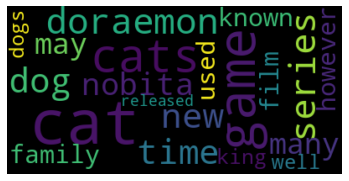

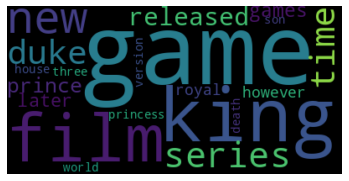

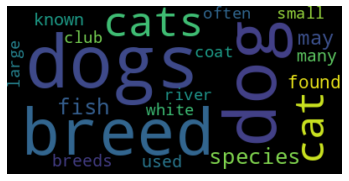

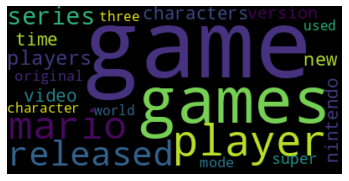

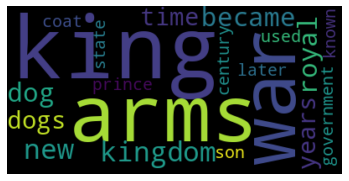

In [291]:
for id in range(5):
    gen_wordcloud(lda_wiki, id)

In [252]:
topic_names = {
  0: 'Cat Games',
  1: 'Games & Movies',
  2: 'Animals',
  3: 'Video Games',
  4: 'War & Kingdoms'
}

In [292]:
def get_topic_from_loc(df, loc):
    d = df.loc[loc]
    s = d[2:].sort_values(ascending=False)
    id = d.values[0]
    url = d.values[1]
    p = np.round(s.values[0], 3)
    tid = s.index[0]
    tname = topic_names[tid]
    print(id)
    print(url)
    print(f'{tname} : {p}')

In [286]:
df.loc[3]

id     2128                                                       
url    https://en.wikipedia.org/wiki/World%27s_Ugliest_Dog_Contest
0      0.335226                                                   
2      0.581411                                                   
4      NaN                                                        
1      0.0751922                                                  
3      NaN                                                        
Name: 3, dtype: object

In [287]:
df.size

39620

In [293]:
get_topic_from_loc(df, 1500)

4393.0
https://en.wikipedia.org/wiki/Newton_Park
Cat Games : 0.998


In [298]:
get_topic_from_loc(df, 1551)

4402.0
https://en.wikipedia.org/wiki/Diana_in_Search_of_Herself
Cat Games : 0.997


In [300]:
get_topic_from_loc(df, 1451)

901.0
https://en.wikipedia.org/wiki/Sabrina:_The_Animated_Series
Video Games : 0.999


### Rating

In [728]:
import copy
xtable_wiki = copy.deepcopy(df_wiki_lda)

In [730]:
def get_best_topic(row):
    s = row.sort_values(ascending=False)
    tid = s.index[0]
    return(tid)
xtable_wiki['topic'] = xtable_wiki.apply(lambda row: get_best_topic(row), axis=1)

In [733]:
xtable_wiki = pd.concat([df_clean.reset_index()['cat'], xtable_wiki], axis=1)

In [734]:
xtable_wiki

,cat,0,2,4,1,3,topic
0,Dogs,0.023813,0.755451,0.220639,NaN,NaN,2
1,Dogs,NaN,0.999395,NaN,NaN,NaN,2
2,Dogs,NaN,0.995707,NaN,NaN,NaN,2
3,Dogs,0.339741,0.580210,NaN,0.071657,NaN,2
4,Fish,NaN,0.971419,NaN,NaN,NaN,2
...,...,...,...,...,...,...,...
5651,Countries,NaN,NaN,0.742952,0.254390,NaN,4
5652,Countries,NaN,NaN,0.156646,0.841662,NaN,1
5653,Countries,NaN,NaN,NaN,0.991992,NaN,1
5654,Countries,NaN,NaN,0.151752,0.847635,NaN,1


In [737]:
def mapy(row):
  l= [0] * 5
  l[row['topic']] = 1
  names = ['cat'] + list(range(5))
  s = pd.Series([row['cat']] + l, index=names)
  return(s)

In [738]:
xtable_wiki = xtable_wiki[['cat'] + list(range(5)) + ['topic']]
xtable_wiki = xtable_wiki.apply(lambda row: mapy(row), axis=1)
xtable_wiki = xtable_wiki.groupby('cat').sum()

In [739]:
xtable_wiki

,0,1,2,3,4
cat,,,,,
Cats,401,399,317,76,207
Countries,45,369,8,2,662
Dogs,73,74,569,20,313
Fish,12,1,1054,0,2
Video_games,7,57,0,988,0


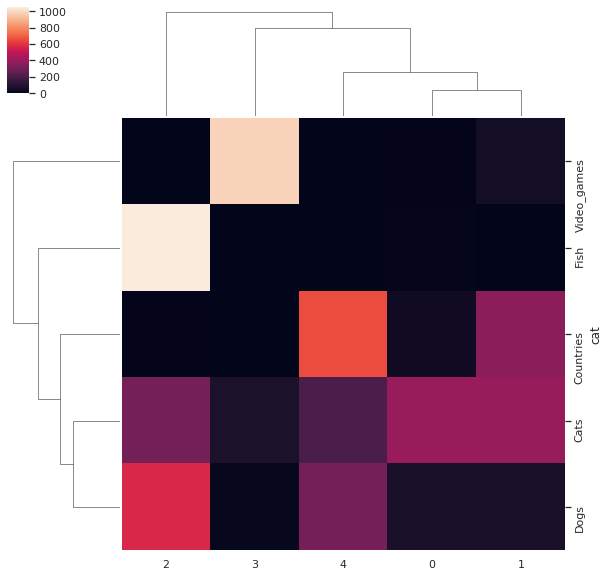

In [740]:
import seaborn as sns; sns.set(color_codes=True)
sns.clustermap(xtable_wiki)